In [5]:
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.metrics import f1_score, precision_score, recall_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import joblib
import os
from typing import Tuple, Dict, Any

Comparing resampling techniques...


C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is i

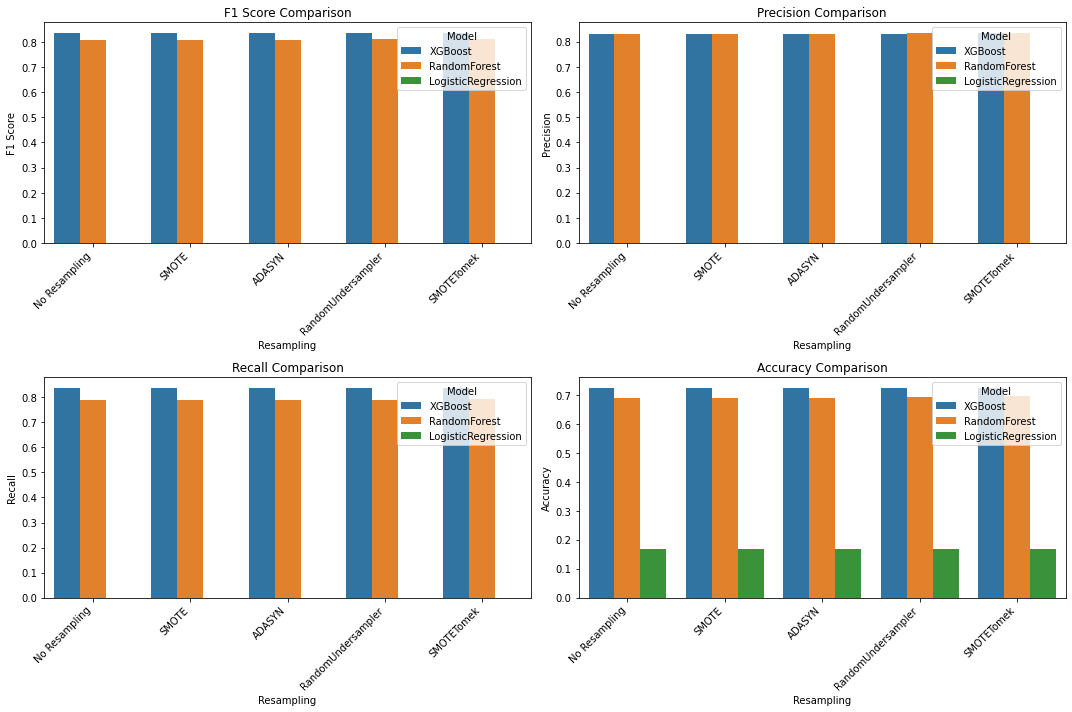


Resampling comparison results:
            Resampling               Model  Accuracy  F1 Score  Precision  \
0        No Resampling             XGBoost  0.724576  0.835276   0.832323   
1        No Resampling        RandomForest  0.688983  0.808355   0.830472   
2        No Resampling  LogisticRegression  0.166949  0.000000   0.000000   
3                SMOTE             XGBoost  0.724576  0.835276   0.832323   
4                SMOTE        RandomForest  0.688983  0.808355   0.830472   
5                SMOTE  LogisticRegression  0.166949  0.000000   0.000000   
6               ADASYN             XGBoost  0.724576  0.835276   0.832323   
7               ADASYN        RandomForest  0.688983  0.808355   0.830472   
8               ADASYN  LogisticRegression  0.166949  0.000000   0.000000   
9   RandomUndersampler             XGBoost  0.724576  0.835276   0.832323   
10  RandomUndersampler        RandomForest  0.693220  0.811065   0.832797   
11  RandomUndersampler  LogisticRegression  

In [7]:
class DataPreprocessor(ABC):
    """Interface for data preprocessing"""
    @abstractmethod
    def preprocess(self, data: pd.DataFrame) -> pd.DataFrame:
        pass

class FeatureEngineer(ABC):
    """Interface for feature engineering"""
    @abstractmethod
    def engineer_features(self, data: pd.DataFrame) -> pd.DataFrame:
        pass

class DataResampler(ABC):
    """Interface for data resampling"""
    @abstractmethod
    def resample(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        pass

class ModelTrainer(ABC):
    """Interface for model training"""
    @abstractmethod
    def train(self, X_train: pd.DataFrame, y_train: pd.Series):
        pass
    
    @abstractmethod
    def predict(self, X_test: pd.DataFrame):
        pass

class ModelSaver(ABC):
    """Interface for model persistence"""
    @abstractmethod
    def save(self, model, filepath: str):
        pass
    
    @abstractmethod
    def load(self, filepath: str):
        pass

class CreditRiskPreprocessor(DataPreprocessor):
    def __init__(self, feature_columns=None):
        self.feature_columns = feature_columns
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
    
    def preprocess(self, data: pd.DataFrame) -> pd.DataFrame:
        processed_data = data.copy()
        
        # Handle missing values
        for col in processed_data.columns:
            if processed_data[col].dtype in ['object']:
                processed_data[col].fillna(processed_data[col].mode()[0], inplace=True)
            else:
                processed_data[col].fillna(processed_data[col].median(), inplace=True)
        
        # Encode categorical variables
        categorical_cols = processed_data.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            processed_data[col] = self.label_encoder.fit_transform(processed_data[col].astype(str))
        
        return processed_data

class CreditRiskFeatureEngineer(FeatureEngineer):
    def engineer_features(self, data: pd.DataFrame) -> pd.DataFrame:
        engineered_data = data.copy()
        
        # Create new features
        engineered_data['Total_Income'] = engineered_data['ApplicantIncome'] + engineered_data['CoapplicantIncome']
        engineered_data['Loan_Income_Ratio'] = engineered_data['LoanAmount'] / (engineered_data['Total_Income'] + 1)
        
        # Log transformations
        log_cols = ['ApplicantIncome', 'LoanAmount', 'Total_Income']
        for col in log_cols:
            if col in engineered_data.columns:
                engineered_data[f'{col}_Log'] = np.log1p(engineered_data[col])
        
        # Polynomial features
        engineered_data['Income_Squared'] = engineered_data['Total_Income'] ** 2
        engineered_data['Loan_Amount_Squared'] = engineered_data['LoanAmount'] ** 2
        
        return engineered_data

class SMOTETomekResampler(DataResampler):
    def __init__(self, random_state: int = 42):
        self.resampler = SMOTETomek(random_state=random_state)
    
    def resample(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        return self.resampler.fit_resample(X, y)

class SMOTEResampler(DataResampler):
    def __init__(self, random_state: int = 42):
        self.resampler = SMOTE(random_state=random_state)
    
    def resample(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        return self.resampler.fit_resample(X, y)

class ADASYNResampler(DataResampler):
    def __init__(self, random_state: int = 42):
        self.resampler = ADASYN(random_state=random_state)
    
    def resample(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        return self.resampler.fit_resample(X, y)

class RandomUndersampler(DataResampler):
    def __init__(self, random_state: int = 42):
        self.resampler = RandomUnderSampler(random_state=random_state)
    
    def resample(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        return self.resampler.fit_resample(X, y)

class XGBoostModelTrainer(ModelTrainer):
    def __init__(self, params=None):
        self.model = None
        self.params = params or {}
    
    def train(self, X_train: pd.DataFrame, y_train: pd.Series):
        self.model = xgb.XGBClassifier(random_state=42, **self.params)
        self.model.fit(X_train, y_train)
        return self
    
    def predict(self, X_test: pd.DataFrame):
        if self.model is None:
            raise ValueError("Model not trained yet")
        return self.model.predict(X_test)
    
    def predict_proba(self, X_test: pd.DataFrame):
        if self.model is None:
            raise ValueError("Model not trained yet")
        return self.model.predict_proba(X_test)

class JobLibModelSaver(ModelSaver):
    def save(self, model, filepath: str):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        joblib.dump(model, filepath)
    
    def load(self, filepath: str):
        return joblib.load(filepath)

class CreditRiskAnalyzer:
    """Main class orchestrating the credit risk analysis process"""
    def __init__(self, 
                 preprocessor: DataPreprocessor,
                 feature_engineer: FeatureEngineer,
                 model_trainer: ModelTrainer,
                 model_saver: ModelSaver,
                 resampler: DataResampler = None):
        self.preprocessor = preprocessor
        self.feature_engineer = feature_engineer
        self.model_trainer = model_trainer
        self.model_saver = model_saver
        self.resampler = resampler
        self.feature_columns = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
    
    def prepare_data(self, data: pd.DataFrame, target_column: str='Loan_Status', test_size: float=0.2):
        # Preprocess
        processed_data = self.preprocessor.preprocess(data)
        
        # Engineer features
        engineered_data = self.feature_engineer.engineer_features(processed_data)
        
        # Define feature columns if not set
        if self.feature_columns is None:
            self.feature_columns = [
                col for col in [
                    'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                    'Loan_Amount_Term', 'Credit_History', 'Total_Income', 
                    'Loan_Income_Ratio', 'ApplicantIncome_Log', 'LoanAmount_Log', 
                    'Total_Income_Log', 'Income_Squared', 'Loan_Amount_Squared'
                ] if col in engineered_data.columns
            ]
        
        # Prepare features and target
        X = engineered_data[self.feature_columns]
        y = engineered_data[target_column]
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # Apply resampling if resampler is provided
        if self.resampler:
            self.X_train, self.y_train = self.resampler.resample(self.X_train, self.y_train)
        
        return self
    
    def compare_resampling_techniques(self) -> pd.DataFrame:
        """Compare different resampling techniques with various models"""
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data not prepared yet. Call prepare_data first.")
        
        resamplers = {
            'No Resampling': None,
            'SMOTE': SMOTEResampler(),
            'ADASYN': ADASYNResampler(),
            'RandomUndersampler': RandomUndersampler(),
            'SMOTETomek': SMOTETomekResampler()
        }
        
        models = {
            'XGBoost': xgb.XGBClassifier(random_state=42),
            'RandomForest': RandomForestClassifier(random_state=42),
            'LogisticRegression': LogisticRegression(random_state=42)
        }
        
        results = []
        
        for resampler_name, resampler in resamplers.items():
            X_train, y_train = self.X_train, self.y_train
            
            if resampler:
                X_train, y_train = resampler.resample(self.X_train, self.y_train)
            
            for model_name, model in models.items():
                model.fit(X_train, y_train)
                y_pred = model.predict(self.X_test)
                
                results.append({
                    'Resampling': resampler_name,
                    'Model': model_name,
                    'Accuracy': model.score(self.X_test, self.y_test),
                    'F1 Score': f1_score(self.y_test, y_pred),
                    'Precision': precision_score(self.y_test, y_pred),
                    'Recall': recall_score(self.y_test, y_pred)
                })
        
        results_df = pd.DataFrame(results)
        self._plot_resampling_comparison(results_df)
        return results_df
    
    def _plot_resampling_comparison(self, results_df: pd.DataFrame):
        """Plot resampling comparison results"""
        plt.figure(figsize=(15, 10))
        
        metrics = ['F1 Score', 'Precision', 'Recall', 'Accuracy']
        for i, metric in enumerate(metrics, 1):
            plt.subplot(2, 2, i)
            sns.barplot(x='Resampling', y=metric, hue='Model', data=results_df)
            plt.title(f'{metric} Comparison')
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    def train_model(self):
        """Train the model with the prepared data"""
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data not prepared yet. Call prepare_data first.")
        
        self.model_trainer.train(self.X_train, self.y_train)
        return self
    
    def evaluate_model(self):
        """Evaluate the trained model"""
        if not hasattr(self.model_trainer, 'model') or self.model_trainer.model is None:
            raise ValueError("Model not trained yet")
        
        y_pred = self.model_trainer.predict(self.X_test)
        
        metrics = {
            'accuracy': self.model_trainer.model.score(self.X_test, self.y_test),
            'f1': f1_score(self.y_test, y_pred),
            'precision': precision_score(self.y_test, y_pred),
            'recall': recall_score(self.y_test, y_pred)
        }
        
        return metrics
    
    def save_model(self, filepath: str):
        """Save the trained model"""
        if not hasattr(self.model_trainer, 'model') or self.model_trainer.model is None:
            raise ValueError("Model not trained yet")
        
        self.model_saver.save(self.model_trainer.model, filepath)
    
    def load_model(self, filepath: str):
        """Load a trained model"""
        loaded_model = self.model_saver.load(filepath)
        self.model_trainer.model = loaded_model
        return self
    
    def predict_new_data(self, new_data: pd.DataFrame) -> pd.DataFrame:
        """Make predictions on new data"""
        # Preprocess new data
        processed_data = self.preprocessor.preprocess(new_data)
        engineered_data = self.feature_engineer.engineer_features(processed_data)
        
        # Select features
        X_new = engineered_data[self.feature_columns]
        
        # Make predictions
        predictions = self.model_trainer.predict(X_new)
        probabilities = self.model_trainer.predict_proba(X_new)[:, 1]
        
        # Prepare results
        results = new_data.copy()
        results['Predicted_Loan_Status'] = predictions
        results['Loan_Approval_Probability'] = probabilities
        
        return results

def main():
    # Initialize components
    preprocessor = CreditRiskPreprocessor()
    feature_engineer = CreditRiskFeatureEngineer()
    resampler = SMOTETomekResampler()  # Using SMOTETomek as default
    model_trainer = XGBoostModelTrainer()
    model_saver = JobLibModelSaver()
    
    # Create analyzer
    analyzer = CreditRiskAnalyzer(
        preprocessor=preprocessor,
        feature_engineer=feature_engineer,
        model_trainer=model_trainer,
        model_saver=model_saver,
        resampler=resampler  # Add resampler
    )
    
    # Load and prepare training data
    train_data = pd.read_csv('credit-worthiness-prediction/train.csv')
    analyzer.prepare_data(train_data)
    
    # Compare different resampling techniques
    print("Comparing resampling techniques...")
    resampling_results = analyzer.compare_resampling_techniques()
    print("\nResampling comparison results:")
    print(resampling_results)
    
   # Train and evaluate model
    analyzer.train_model()
    metrics = analyzer.evaluate_model()
    print("Model Performance Metrics:", metrics)
    
    # Save the model
    analyzer.save_model('models/credit_risk_model.joblib')
    
    # Load test data and make predictions
    test_data = pd.read_csv('credit-worthiness-prediction/test.csv')
    predictions = analyzer.predict_new_data(test_data)
    print("\nPredictions for test data:")
    print(predictions.head())

if __name__ == "__main__":
    main()